# Exercise Session 3
## Template Matching


### Import libraries

In [1]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.6.0


### Set seed for reproducibility

In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

## CIFAR-10

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

Class labels:

0: airplane

1: automobile

2: bird

3: cat

4: deer

5: dog

6: frog

7: horse

8: ship

9: truck

In [3]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.cifar10.load_data()
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

((50000, 32, 32, 3), (50000, 1), (10000, 32, 32, 3), (10000, 1))

In [4]:
# Concatenate train and test (ONLY for visualization purposes)
X = np.concatenate([X_train_val,X_test],axis=0)
y = np.concatenate([y_train_val,y_test],axis=0)
labels = {0:'airplane', 1:'automobile', 2:'bird', 3:'cat', 4:'deer', 5:'dog', 6:'frog', 7:'horse', 8:'ship', 9:'truck'}

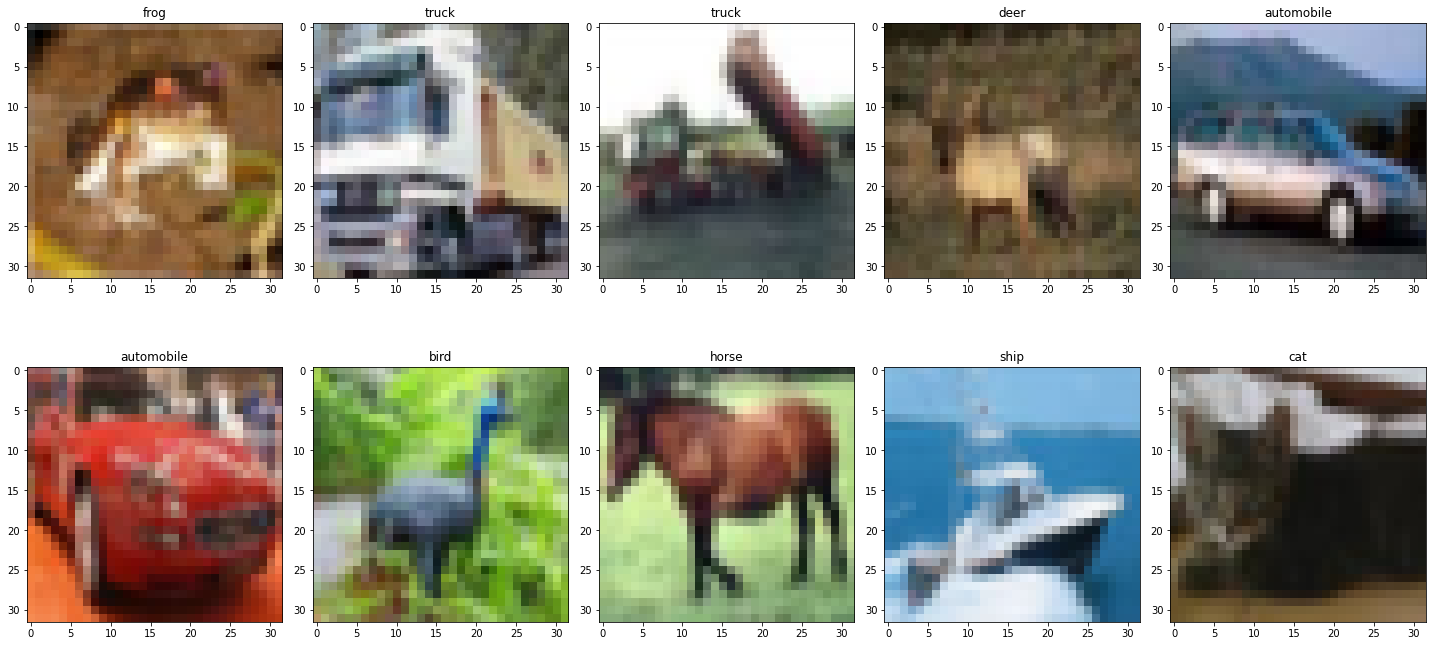

In [5]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X[i])
    ax.set_title('{}'.format(labels[y[i][0]]))
plt.tight_layout()
plt.show()

### (OPTIONAL) Reduce Label Space


In [6]:
# Take only data corresponding to automobile, horse or ship labels
y = pd.DataFrame(y, columns=['Label'])
y = y.loc[(y['Label']==1) | (y['Label']==7) | (y['Label']==8)]
y.loc[y['Label']==7] = 0
y.loc[y['Label']==8] = 2
X = X[y.index.to_numpy()]
y = y.values

### Process Data

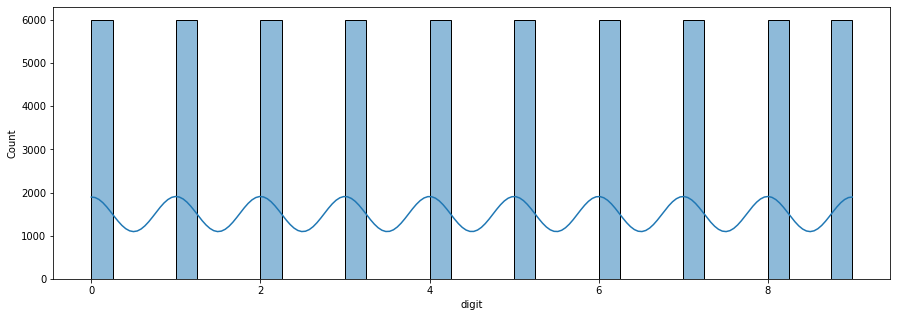

In [7]:
# Normalize data
X = X/255.

# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(y, columns=['digit']), x='digit', kde=True)
plt.show()

In [9]:
# Categorize labels
# e.g.
# 2 -> [0,0,1,0,0,0,0,0,0,0,0]
y = tfk.utils.to_categorical(y)

### Model metadata

In [20]:
input_shape = X.shape[1:]
batch_size = 16
epochs = 100

### Linear model

In [33]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    flattening_layer = tfkl.Flatten(name='Flatten')(input_layer)
    output_layer = tfkl.Dense(units=10, activation='softmax', name='Output')(flattening_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss='categorical_hinge', optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 32, 32, 3)]       0         
_________________________________________________________________
Flatten (Flatten)            (None, 3072)              0         
_________________________________________________________________
Output (Dense)               (None, 10)                30730     
Total params: 30,730
Trainable params: 30,730
Non-trainable params: 0
_________________________________________________________________


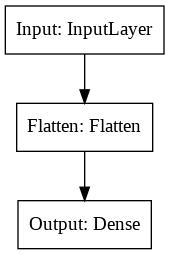

In [34]:
model = build_model(input_shape)
model.summary()
tfk.utils.plot_model(model)

In [35]:
history = model.fit(
    x = X,
    y = y,
    batch_size = batch_size,
    epochs = epochs
).history

Epoch 1/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2316 - accuracy: 0.1733
Epoch 2/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2355 - accuracy: 0.1709
Epoch 3/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2480 - accuracy: 0.1736
Epoch 4/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2447 - accuracy: 0.1756
Epoch 5/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2273 - accuracy: 0.1800
Epoch 6/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2108 - accuracy: 0.1816
Epoch 7/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2783 - accuracy: 0.1769
Epoch 8/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2406 - accuracy: 0.1809
Epoch 9/100
3750/3750 [==============================] - 9s 2ms/step - loss: 1.2397 - accuracy: 0.1749
Epoch 10/100
3750/3750 [==============================] - 9s 2ms/step - l

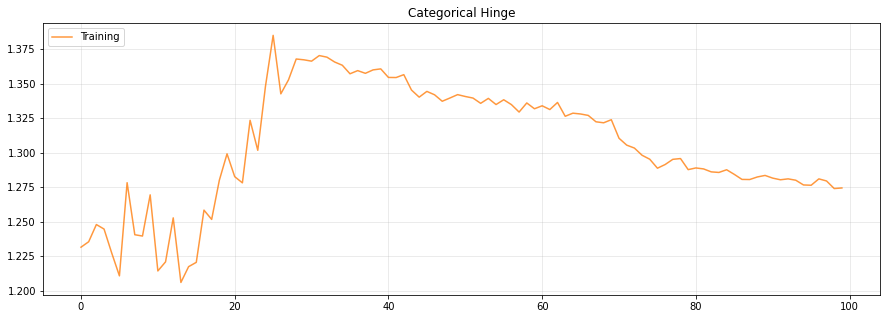

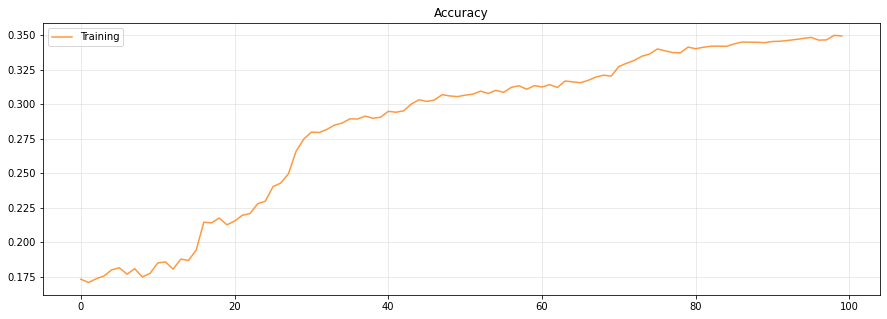

In [36]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Categorical Hinge')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [37]:
weights = model.layers[-1].get_weights()[0]
biases  = model.layers[-1].get_weights()[1]

r_channel = weights[np.arange(0,len(weights),3),:]
g_channel = weights[np.arange(1,len(weights),3),:]
b_channel = weights[np.arange(2,len(weights),3),:]
r_channel = np.reshape(r_channel, (32,32,10,1))
g_channel = np.reshape(g_channel, (32,32,10,1))
b_channel = np.reshape(b_channel, (32,32,10,1))
r_channel.shape, g_channel.shape, b_channel.shape

((32, 32, 10, 1), (32, 32, 10, 1), (32, 32, 10, 1))

In [44]:
channels_weights = np.concatenate([r_channel,g_channel,b_channel], axis=-1)

normalize = True
if(normalize):
    channels_weights = (channels_weights-channels_weights.min())/(channels_weights.max()-channels_weights.min())

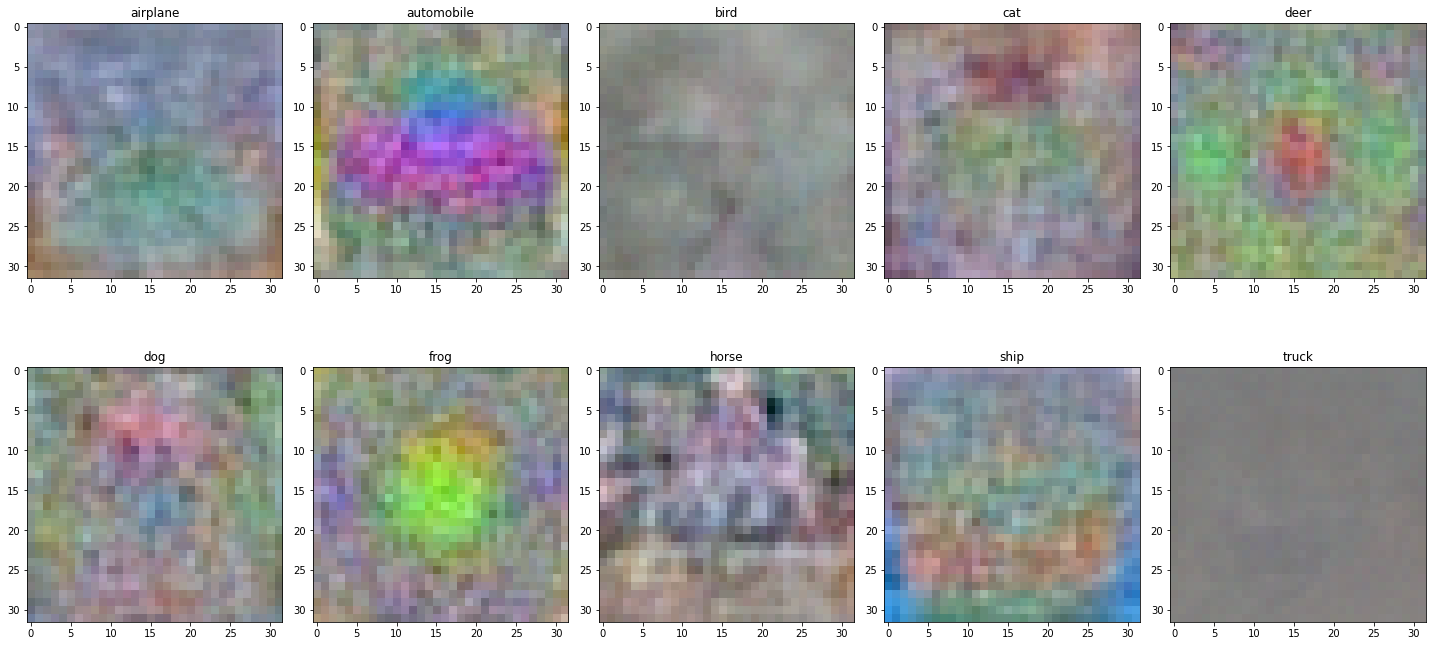

In [45]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(channels_weights[:,:,i,:])
    ax.set_title('{}'.format(labels[i]))
plt.tight_layout()
plt.show()

### Sanity Check

In [26]:
layer_output=model.get_layer('Flatten').output
intermediate_model=tfk.models.Model(inputs=model.input,outputs=layer_output)
intermediate_prediction=intermediate_model.predict(X)
intermediate_prediction.shape

(60000, 3072)

In [27]:
idx=6
r_channel = intermediate_prediction[idx][np.arange(0,len(weights),3)]
g_channel = intermediate_prediction[idx][np.arange(1,len(weights),3)]
b_channel = intermediate_prediction[idx][np.arange(2,len(weights),3)]

r_channel = np.reshape(r_channel, (32,32,1))
g_channel = np.reshape(g_channel, (32,32,1))
b_channel = np.reshape(b_channel, (32,32,1))

r_channel.shape, g_channel.shape, b_channel.shape

((32, 32, 1), (32, 32, 1), (32, 32, 1))

In [28]:
activation = np.concatenate([r_channel,g_channel,b_channel], axis=-1)
activation.shape

(32, 32, 3)

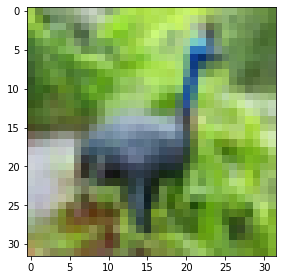

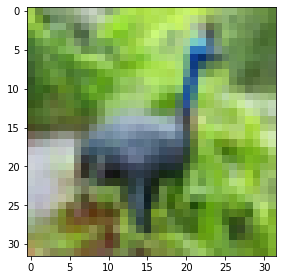

In [29]:
plt.imshow(X_train_val[idx])
plt.tight_layout()
plt.show()
plt.imshow(activation)
plt.tight_layout()
plt.show()

## MNIST

The MNIST database, an extension of the NIST database, is a low-complexity data collection of handwritten digits used to train and test various supervised machine learning algorithms. The database contains 70,000 28x28 black and white images representing the digits zero through nine. The data is split into two subsets, with 60,000 images belonging to the training set and 10,000 images belonging to the testing set. 

In [30]:
(X_train_val, y_train_val), (X_test, y_test) = tfk.datasets.mnist.load_data()
X_train_val.shape, y_train_val.shape, X_test.shape, y_test.shape

11501568/11490434 [==============================] - 0s 0us/step


((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [31]:
# Concatenate train and test (ONLY for visualization purposes)
X_mnist = np.concatenate([X_train_val,X_test],axis=0)
y_mnist = np.concatenate([y_train_val,y_test],axis=0)

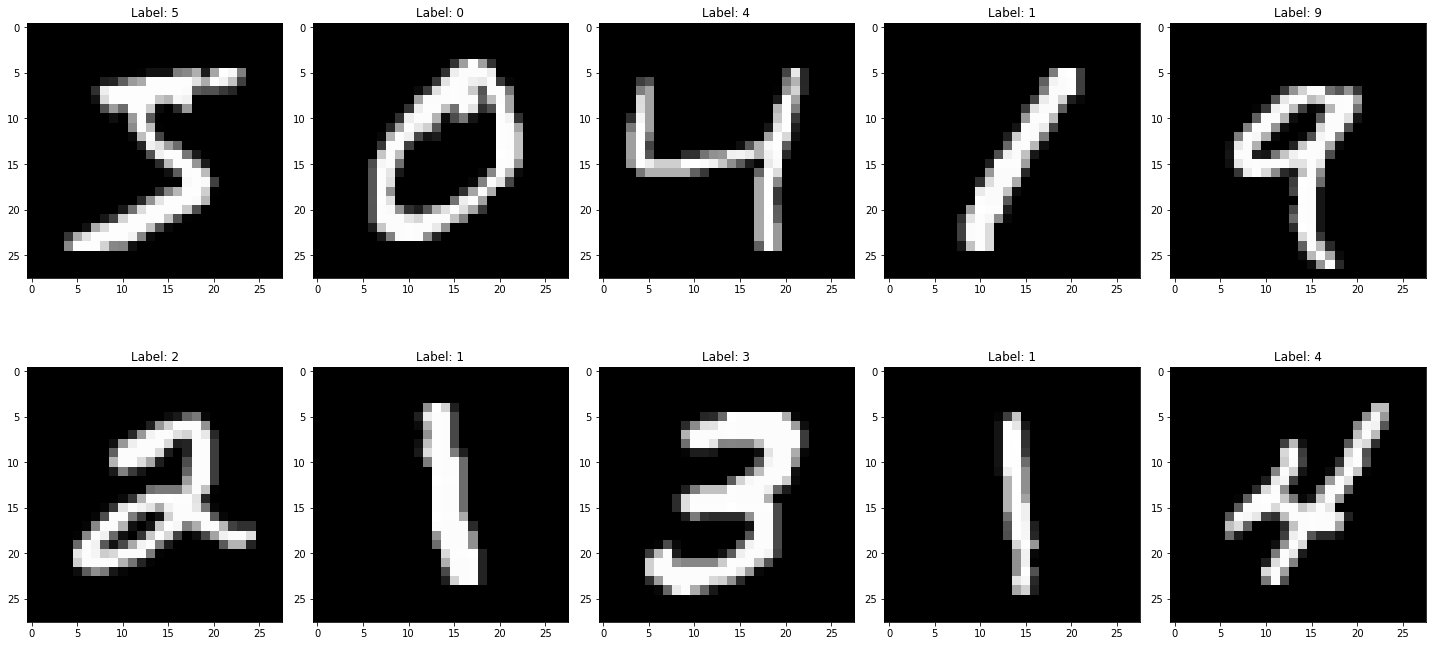

In [32]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(X_mnist[i], cmap='gray')
    ax.set_title('Label: {}'.format(y_mnist[i]))
plt.tight_layout()
plt.show()

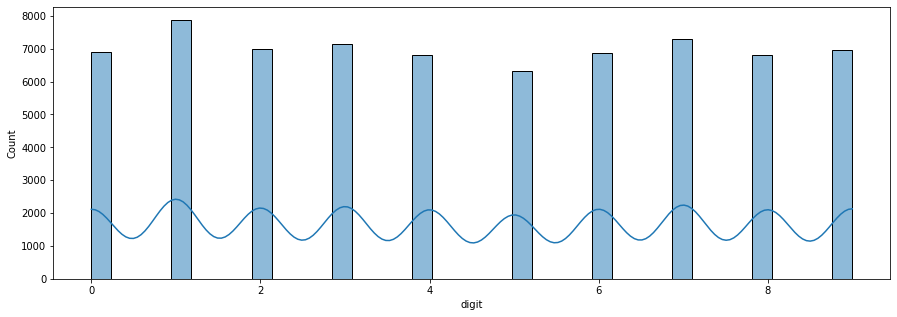

In [33]:
# Inspect the target
plt.figure(figsize=(15,5))
sns.histplot(data=pd.DataFrame(y_mnist, columns=['digit']), x='digit', kde=True)
plt.show()

### Process Data

In [34]:
# Normalize data
X_mnist = X_mnist/255.

# Categorize labels
# e.g.
# 3 -> [0,0,0,1,0,0,0,0,0,0,0]
y_mnist = tfk.utils.to_categorical(y_mnist)

### Model metadata

In [35]:
input_shape_mnist = X_mnist.shape[1:]
batch_size_mnist = 64
epochs_mnist = 100

### Linear model

In [36]:
def build_model(input_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    flattening_layer = tfkl.Flatten(name='Flatten')(input_layer)
    output_layer = tfkl.Dense(units=10, activation='softmax', name='Output')(flattening_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    # model.compile(loss='categorical_hinge', optimizer=tfk.optimizers.Adam(), metrics='accuracy')
    model.compile(loss='categorical_hinge', optimizer=tfk.optimizers.Adam(), metrics='accuracy')

    # Return the model
    return model

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input (InputLayer)           [(None, 28, 28)]          0         
_________________________________________________________________
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
Output (Dense)               (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


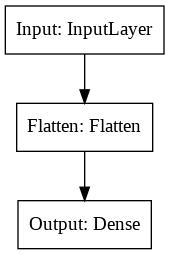

In [37]:
model = build_model(input_shape_mnist)
model.summary()
tfk.utils.plot_model(model)

In [38]:
history = model.fit(
    x = X_mnist,
    y = y_mnist,
    batch_size = batch_size_mnist,
    epochs = epochs_mnist
).history

Epoch 1/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.3782 - accuracy: 0.8553
Epoch 2/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.2235 - accuracy: 0.9087
Epoch 3/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1970 - accuracy: 0.9164
Epoch 4/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1833 - accuracy: 0.9206
Epoch 5/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1741 - accuracy: 0.9238
Epoch 6/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1676 - accuracy: 0.9262
Epoch 7/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1624 - accuracy: 0.9282
Epoch 8/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1583 - accuracy: 0.9296
Epoch 9/100
1094/1094 [==============================] - 4s 4ms/step - loss: 0.1549 - accuracy: 0.9306
Epoch 10/100
1094/1094 [==============================] - 4s 4ms/step - l

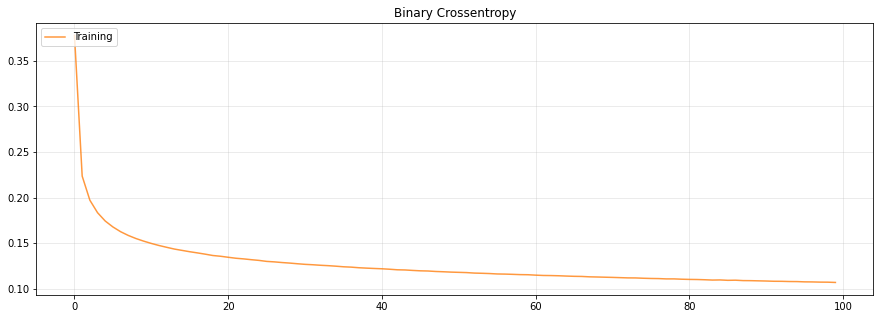

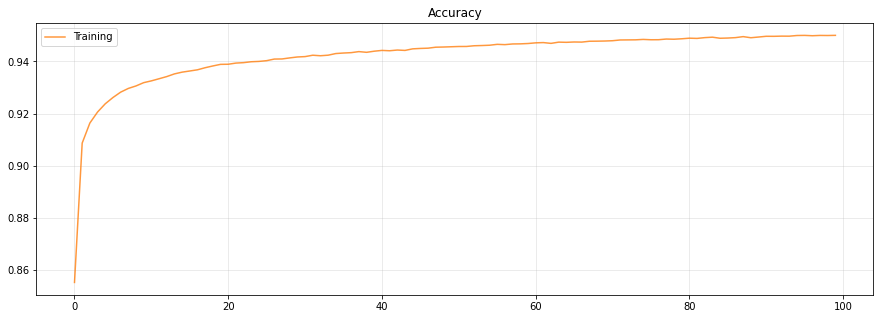

In [39]:
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Binary Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [40]:
weights = model.layers[-1].get_weights()[0]
biases  = model.layers[-1].get_weights()[1]

gray_channel = np.reshape(weights, (28,28,10))
gray_channel = (gray_channel-gray_channel.min())

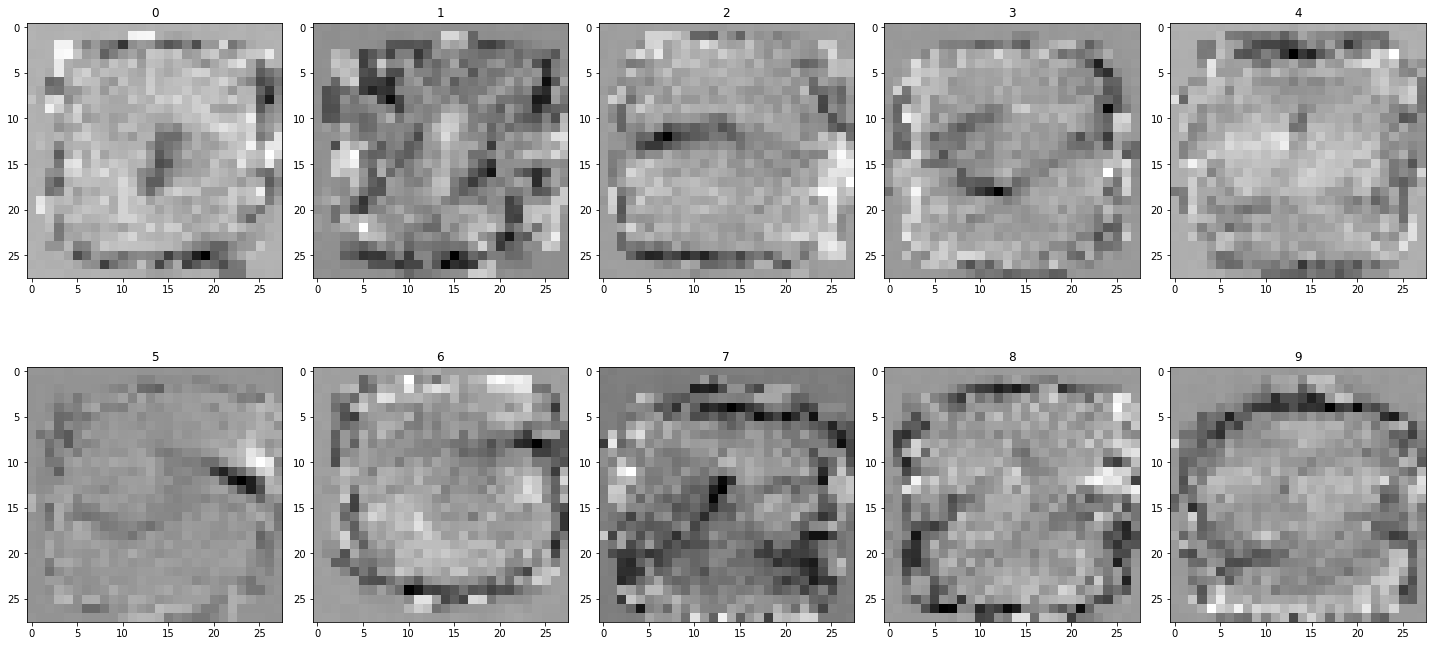

In [41]:
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(10*num_row,2*num_col))
for i in range(num_row*num_col):
    ax = axes[i//num_col, i%num_col]
    ax.imshow(gray_channel[:,:,i], cmap='gray')
    ax.set_title('{}'.format(i))
plt.tight_layout()
plt.show()